# Data Processing and Beamforming

### Importing

In [1]:
import numpy as np
import imagesc as imagesc
import pandas as pd
import matplotlib.pyplot as plt
import geopy
import geopy.distance
import pickle

from tqdm import tqdm
from pydsm.relab import shiftdim
from obspy.clients.fdsn import Client 
from obspy import UTCDateTime
from obspy.core.stream import Stream
from time import sleep


### Method Definition

In [2]:

def __get_array_stations(seed_id, tbeg, tend):

    net, sta, loc, cha  = seed_id.split(".")

    inv_check = Client("IRIS").get_stations(
                                       network=net, 
                                       station=sta,
                                       channel=cha,
                                       starttime=tbeg,
                                       endtime=tend
                                        )
    
    
    #inv_check.plot() 
    inv_check.plot(projection="local");
    
    codes, lon, lat = [], [], []
    for network in inv_check:
        for i, station in enumerate(network):
            
            codes.append(station.code)
            lon.append(station.longitude)
            lat.append(station.latitude)

    

    return codes, np.array([lon, lat])


In [23]:

def __get_waveforms(seed_id, array_stations, tbeg, tend):

    net, sta, loc, cha  = seed_id.split(".")
    
    waveform = Stream()

    bad = []
    
    print("requesting waveforms ..."); sleep(1)
    for num in tqdm(np.arange(len(array_stations))):
        try:
            inv = c.get_stations(network  = net,
                                 station  = array_stations[num],
                                 location = loc,
                                 channel  = cha,
                                 starttime= tbeg,
                                 endtime  = tend,
                                 level    = 'response'
                                )

            st  = c.get_waveforms(network  = net,
                                  station  = array_stations[num],
                                  location = loc,
                                  channel  = cha,
                                  starttime= tbeg,
                                  endtime  = tend
                                 )

            st.merge(method=1,
                     fill_value='interpolate',
                     interpolation_samples=2
                    )

            st.remove_response(inventory=inv, output='VEL')

            st.detrend('simple')

            waveform += st
            
        except:
            bad.append(f'{net}.{array_stations[num]}')
            
            
    if bad != []:
        print(f"bad request for {len(bad)} stations")
    
    return waveform


In [33]:

def __calulcate_beam_power(inp):
    
    ## relevant parameters for frequency domain
    dt   = waveform1[0].stats.delta  ## sampling interval
    Fmax = np.int(1/dt); ## maximum frequency
    Nfft = waveform1[0].stats.npts ## number of sample in each chopped seismogram (i.e. number in fft)
    frq  = Fmax/2*np.linspace(0,1,endpoint=True, num=np.int(Nfft/2+1)); ## central frequencies

    beam = np.zeros([len(NsloV),len(EsloV)])

    for ind1 in np.arange(len(NsloV)):

        for ind2 in np.arange(len(EsloV)):

            stdel = np.zeros([len(inp)])

            for ind3 in np.arange(array_coords.shape[0]):

                delay = -1*(distN[ind3]*NsloV[ind1] + distE[ind3]*EsloV[ind2]) ##compute lag from slownesses 
                rep   = np.exp(1j*2*np.pi*frq*delay)
                vehlp = np.fft.fft(inp[:,ind3])
                shft  = shiftdim(vehlp[0:len(frq)],1,nargout=1)
                dshft = rep.T*shft
                s_sh  = np.double(2*np.real(np.fft.ifft(dshft, Nfft)))
                stdel = stdel + s_sh/np.max(np.abs(s_sh))

            beam[ind1,ind2] = np.sum((stdel/len(inp))**2)


    ## determine peak
    indextuple = np.unravel_index(np.argmax(beam, axis=None), beam.shape)

    beampeak = beam[indextuple]

    beampeak_y = NsloV[indextuple[0]]
    beampeak_x = EsloV[indextuple[1]]

    ## calculate back azimuth
    baz = np.rad2deg(np.arctan2(beampeak_x,beampeak_y))
    
    print('Slowness [s/km]: %g'%(np.sqrt(beampeak_x**2+beampeak_x**2) ))
    print(f'Back azimuth from North [degree]: {baz}')

    return beam, beampeak_x, beampeak_y, baz


The next few methods define various plots in detail

In [97]:

def __plot_pinpoint_origin():

    fig = plt.figure(figsize=(10, 10))

    ## plot array stations
    plt.plot(array_coords[:][0], array_coords[:][1], 'ko')

    ## add array center
    plt.plot(acent[0], acent[1], 'rp')

    ## add event location
    plt.plot(event_lon, event_lat,'b*', markersize=10) 

    ##Add ray tracing in surface 
    # Define starting point, array center
    start = geopy.Point(acent[1], acent[0])

    print(start)

    # Define a general distance object, initialized with a distance of 10 km.
    d = geopy.distance.distance(kilometers = 10)

    # Use the `destination` method with a bearing of backazimuth degrees (which is north)
    # in order to go from point `start` 10 km to north.
    A = d.destination(point=start, bearing=-baz)
    endpoint = [A[0], A[1]]

    plt.plot([acent[0],A[1]], [acent[1], A[0]], 'k--')
    
    
    plt.xlabel('Longtidue (°)',fontsize=15)
    plt.ylabel('Latitude (°)',fontsize=15)
    
    plt.show();
    return fig


In [6]:

def __plot_array_section(st, scal): 
    
    fig, ax = plt.subplots(1,1, figsize=(13,6))
    
    for istation in range(len(st)):
        tmp = st[istation].data
        
        if len(tmp) == 0:
            print('no data for station:', st[istation].stats.station)
        
        else:
            if scal > 0:
                tmp1 = tmp/(np.max(tmp)-np.min(tmp))
            else:
                tmp1 = tmp
            
            timeline = np.arange(0,len(tmp1),1)*st[istation].stats.delta
            
            ax.plot(timeline, tmp1*np.abs(scal)+istation*np.abs(scal),'k')
    
    ax.set_yticks(np.arange(0,len(st), 1)*scal)
    ax.set_yticklabels(np.arange(0,len(st),1)+1)
    ax.set_xlabel(f'Time from {st[0].stats.starttime.date} {st[0].stats.starttime.time} (s)', fontsize=15, labelpad=10)
    
    plt.show();
    return fig


In [7]:

def __plot_slowness_grid():
    
    fs = 12

    fig = plt.figure(figsize=(8,8))
    plt.imshow(beam,
               origin='lower',
               extent=[-maximal_slowness, maximal_slowness ,-maximal_slowness ,maximal_slowness], 
               )

    plt.plot([beampeak_x], [beampeak_y], 'kp')
    
    plt.xlabel('East Slowness (s/km)', fontsize=fs)
    plt.ylabel('North Slowness (s/km)', fontsize=fs)
    plt.colorbar(label="beam power")
    plt.title('Slowness grid', fontsize=fs+3)

    plt.show();
    return fig


### Variable Setup

In [148]:
# set up the data client
c = Client("IRIS")


##an earthquakes in this time window, 2011/06/06 12:17:00.17 eq  l 0.81 l   33.65350 -116.71767  12.4 A 14996836   34  775
tbeg = UTCDateTime("2011-06-06T12:17:00.000")
tend = UTCDateTime("2011-06-06T12:17:10.000")

## network and station codes
code = "ZZ.GA*..SHZ"
code = "ZZ.AZ*..SHZ"

## event epicenter
event_lon, event_lat = -116.71767, 33.65350

## defie output path
opath = "/home/andbro/notebooks/backprojections/data/"

# Part 1:

### Obtaining Data 

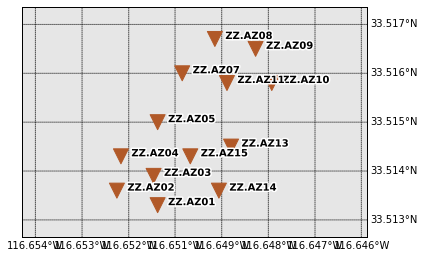

requesting waveforms ...


100%|██████████| 13/13 [00:38<00:00,  2.99s/it]

bad request for 3 stations


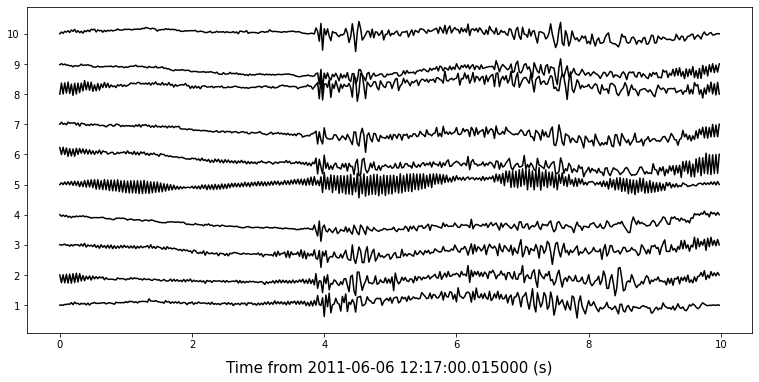

In [149]:
## station codes
net, sta, loc, cha  = code.split(".")


## request station data
array_stations, array_coords = __get_array_stations(code, tbeg, tend)


##array center location in lon-lat
acent = [np.mean(array_coords[0][:]), np.mean(array_coords[1][:])] 


## request waveform data
waveforms0 = __get_waveforms(code, array_stations, tbeg, tend)   


## find the common time base for the data           
tbeg_new = max([tr.stats.starttime for tr in waveforms])
tend_new = min([tr.stats.endtime for tr in waveforms])

## trim the waveform to the same duration
waveforms0.trim(tbeg_new, tend_new, nearest_sample=True);


## plotting the waveforms as section
__plot_array_section(waveforms0, scal=1);

### Waveform Processing

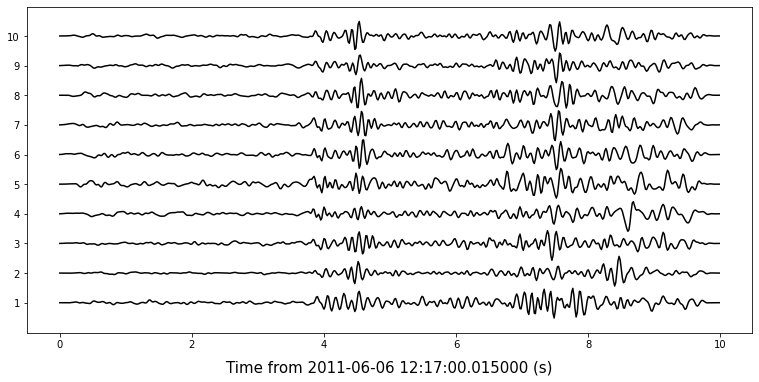

In [150]:
##resampling data to the same sampling rate and detrend, frequency filter the data
freq_resampling = 60.
freqmin_select  = 1.
freqmax_select  = 15.

waveforms = waveforms0.copy()

waveforms.resample(freq_resampling);

waveforms.detrend('demean');

waveforms.filter('bandpass', 
                freqmin=freqmin_select, 
                freqmax=freqmax_select, 
                corners=4, 
                zerophase=True,
               );

waveforms.taper(max_percentage = 0.05);


## plotting the waveforms as section
__plot_array_section(waveforms, scal=1);

### Select time window for P-phase

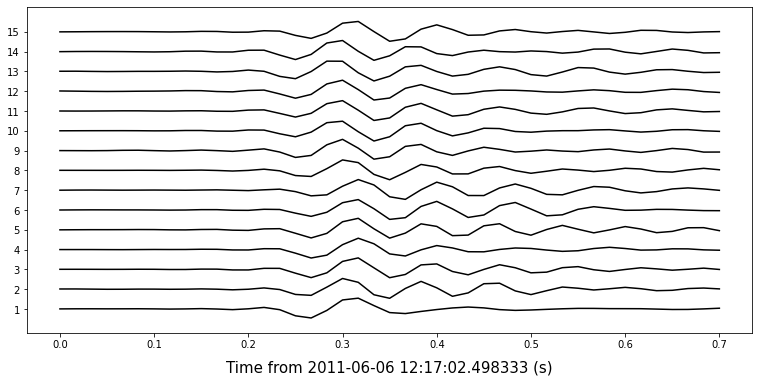

In [93]:
## select start and endtime for p-phase
pbeg = UTCDateTime("2011-06-06T12:17:02.500")
pend = UTCDateTime("2011-06-06T12:17:03.200")


##f-k analysis
waveform1 = waveforms.copy()


##select the time window for beamforming
waveform1.trim(starttime = pbeg,
               endtime = pend,
               nearest_sample = True,
              );

## plotting the waveforms as section
__plot_array_section(waveform1, scal=5);

### Calculate Geometry

In [94]:
Npts = len(waveform1[0].data)

tmp = np.zeros([Npts, len(waveform1)])

for ind in range(len(waveform1)):
    tmp[:,ind] = waveform1[ind].data


## offsets to center of array in km 
distN = (array_coords[0,:] - acent[1])*111.0; 
distE = (array_coords[1,:] - acent[0])*111.0 * np.cos(acent[1]/180*np.pi);


## Slowness domain
maximal_slowness = 0.5
slowness_steps = 0.01

NsloV = np.arange(-maximal_slowness, maximal_slowness + slowness_steps, slowness_steps);
EsloV = np.arange(-maximal_slowness, maximal_slowness + slowness_steps, slowness_steps);


### Slowness Grid Search

A grid search for the slowness field is performed and the slowness used to shift the traces, which are then stacked. This should result in a slowness grid indicating the best slowness by the best stacking result.

Slowness [s/km]: 0.0848528
Back azimuth from North [degree]: 116.56505117707748


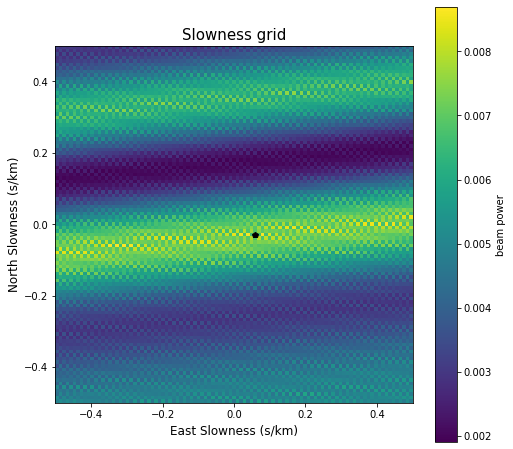

In [95]:
## calculate beam energy for slowness grid
beam, beampeak_x, beampeak_y, baz = __calulcate_beam_power(tmp)

## display beam power for slowness grid
__plot_slowness_grid();

### Pinpoint Origin

33 39m 55.6318s N, 116 39m 0.79152s W


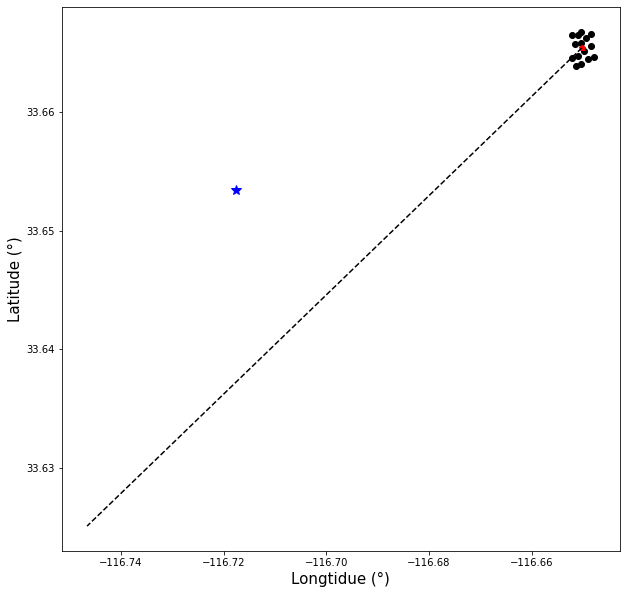

In [98]:
__plot_pinpoint_origin();

### Dumping Data

In [146]:
values_to_store = np.array([event_lon, event_lat, baz])

with open(opath + f'values_{net}_{sta}.pkl', 'wb') as f:
    pickle.dump(values_to_store, f, pickle.HIGHEST_PROTOCOL)

with open(opath + f'waveforms_{net}_{sta}.pkl', 'wb') as f:
    pickle.dump(waveforms, f, pickle.HIGHEST_PROTOCOL)

with open(opath + f'beampower_{net}_{sta}.pkl', 'wb') as f:
    pickle.dump(beam, f, pickle.HIGHEST_PROTOCOL)
    
with open(opath + f'arraycoordinates_{net}_{sta}.pkl', 'wb') as f:
    pickle.dump(array_coords, f, pickle.HIGHEST_PROTOCOL)

# Part 2:

### Load Data of Part 1

In [147]:
net1, sta1 = 'ZZ', 'GA*'
net2, sta2 = 'ZZ', 'AZ*'



waveforms1 = pickle.load( open(opath + f'waveforms_{net1}_{sta1}.pkl', "rb" ) )
waveforms2 = pickle.load( open(opath + f'waveforms_{net2}_{sta2}.pkl', "rb" ) )

beampower1 = pickle.load( open(opath + f'beampower_{net1}_{sta1}.pkl', "rb" ) )
beampower2 = pickle.load( open(opath + f'beampower_{net2}_{sta2}.pkl', "rb" ) )

arraycoordinates1 = pickle.load( open(opath + f'arraycoordinates_{net1}_{sta1}.pkl', "rb" ) )
arraycoordinates2 = pickle.load( open(opath + f'arraycoordinates_{net2}_{sta2}.pkl', "rb" ) )

values1 = pickle.load( open(opath + f'values_{net1}_{sta1}.pkl', "rb" ) )
values2 = pickle.load( open(opath + f'values_{net2}_{sta2}.pkl', "rb" ) )

event_lon, event_lat, baz1 = values1[0], values1[1], values1[2]
event_lon, event_lat, baz2 = values2[0], values2[1], values2[2]


FileNotFoundError: [Errno 2] No such file or directory: '/home/andbro/notebooks/backprojections/data/values_ZZ_AZ*.pkl'

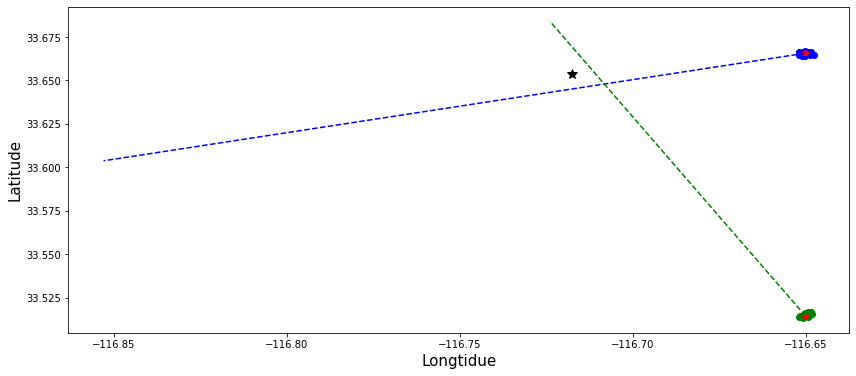

In [140]:
fig = plt.figure(figsize=(14,6))

## plot array stations and array center locations
plt.plot(arraycoordinates1[0,:],arraycoordinates1[1,:],'bo')
plt.plot(np.median(arraycoordinates1[0,:]),np.median(arraycoordinates1[1,:]),'rp')

plt.plot(arraycoordinates2[0,:],arraycoordinates2[1,:],'go')
plt.plot(np.median(arraycoordinates2[0,:]),np.median(arraycoordinates2[1,:]),'rp')

## add event location
plt.plot(event_lon, event_lat,'k*', markersize=10) 

## add ray tracing in surface 
## define starting point, array center
start1 = geopy.Point(np.median(arraycoordinates1[1,:]),np.median(arraycoordinates1[0,:]))
start2 = geopy.Point(np.median(arraycoordinates2[1,:]),np.median(arraycoordinates2[0,:]))


# Define a general distance object, initialized with a distance of 10 km.
d1 = geopy.distance.distance(kilometers = 20)
d2 = geopy.distance.distance(kilometers = 20)

# Use the `destination` method with a bearing of backazimuth degrees (which is north)
# in order to go from point `start` 10 km to north.
A1 = d1.destination(point=start1, bearing=-116.5)
A2 = d2.destination(point=start2, bearing=-20)

plt.plot([np.median(arraycoordinates1[0,:]),A1[1]], [np.median(arraycoordinates1[1,:]), A1[0]], 'b--')
plt.plot([np.median(arraycoordinates2[0,:]),A2[1]], [np.median(arraycoordinates2[1,:]), A2[0]], 'g--')



plt.xlabel('Longtidue',fontsize=15)
plt.ylabel('Latitude',fontsize=15)

plt.show();